# Medical EHR + MRI Summarization & Enhancement Notebook

This notebook is pre-configured to: upload/load your merged EHR CSV and MRI ZIP, run a Hugging Face summarization model, generate image captions using BLIP (with fallback), display MRI images inline, and produce diagnostic reports per patient.

How to use:
1. Run the first cell to install required libraries.
2. Run the upload cell to upload `Merged_EHR_Data.csv` (or `ALL IN ONE.csv`) and your `mri_images.zip`.
3. Run the subsequent cells step-by-step.

In [3]:
# ===============================================
# 📦 MEDICAL EHR + MRI SUMMARIZATION ENVIRONMENT
# ===============================================

# Core Python Libraries
!pip install -q pandas numpy pillow scikit-image matplotlib seaborn tqdm ipywidgets nbformat accelerate

# Machine Learning & Deep Learning
!pip install -q torch torchvision torchaudio

# Hugging Face Transformers (includes BLIP, BART, etc.)
!pip install -q "transformers>=4.41.0,<5.0.0" datasets sentencepiece

# Summarization and Sentence Embedding Models
!pip install -q sentence-transformers evaluate

# Optional: Image visualization & enhancement tools
!pip install -q opencv-python scikit-learn

# System utilities and quality-of-life tools
!pip install -q tqdm rich

print("✅ All required libraries have been installed successfully!")


✅ All required libraries have been installed successfully!


In [6]:
# Upload files (works in Google Colab). If running locally, place files in working directory.
try:
    from google.colab import files, drive
    IN_COLAB = True
except Exception:
    IN_COLAB = False

print('Running in Colab:', IN_COLAB)

if IN_COLAB:
    print('Mounting Google Drive (optional). If you do not want to mount, skip by pressing Ctrl+C when prompted.)')
    try:
        drive.mount('/content/drive')
    except Exception as e:
        print('Drive mount skipped or failed:', e)

    print('\nUse the file-upload widget to upload your files. Upload your merged EHR CSV (e.g., Merged_EHR_Data.csv) and mri_images.zip.')
    uploaded = files.upload()
    for name in uploaded.keys():
        print('Uploaded:', name)
else:
    print('Not in Colab. Make sure your files are in the working directory (or update the paths manually).')

Running in Colab: True
Mounting Google Drive (optional). If you do not want to mount, skip by pressing Ctrl+C when prompted.)
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Use the file-upload widget to upload your files. Upload your merged EHR CSV (e.g., Merged_EHR_Data.csv) and mri_images.zip.


Saving Merged_EHR_Data.csv to Merged_EHR_Data (1).csv
Saving mri_images.zip to mri_images.zip
Uploaded: Merged_EHR_Data (1).csv
Uploaded: mri_images.zip


In [7]:
# Set file paths - adjust if needed.
import os, glob, zipfile, io, json
from pathlib import Path
BASE = Path('/content') if 'google.colab' in str(get_ipython).lower() else Path.cwd()
# Common filenames we expect; if uploaded via Colab these will be in /content/
CSV_OPTIONS = ['Merged_EHR_Data.csv', 'ALL IN ONE.csv', 'ALL_IN_ONE.csv', 'Final_EHR_1200.csv']
ZIP_OPTIONS = ['mri_images.zip', 'enhanced_mri_results.zip', 'TRAIN.zip', 'Images of MRI.zip']

def find_first_existing(options):
    for o in options:
        p = BASE/o
        if p.exists(): return p
    return None

CSV_PATH = find_first_existing(CSV_OPTIONS)
ZIP_PATH = find_first_existing(ZIP_OPTIONS)
EXTRACT_PATH = BASE/'extracted_mri_images'

print('Detected CSV path:', CSV_PATH)
print('Detected ZIP path:', ZIP_PATH)
print('Extract path:', EXTRACT_PATH)

# Safe CSV read
import pandas as pd
def safe_read_csv(path):
    if path is None:
        print('CSV not found. Please upload one of:', CSV_OPTIONS)
        return pd.DataFrame()
    for enc in ['utf-8','latin1','ISO-8859-1']:
        try:
            df = pd.read_csv(path, encoding=enc, low_memory=False)
            print(f'Loaded {path} using encoding {enc}; shape={df.shape}')
            return df
        except Exception as e:
            print(f'Failed to read with {enc}:', e)
    print('All attempts failed. You may need to pre-process the CSV.')
    return pd.DataFrame()

df = safe_read_csv(CSV_PATH)
df.columns = [c.strip() for c in df.columns]
print('\nColumns found:\n', df.columns.tolist())

Detected CSV path: /content/Merged_EHR_Data.csv
Detected ZIP path: /content/mri_images.zip
Extract path: /content/extracted_mri_images
Loaded /content/Merged_EHR_Data.csv using encoding utf-8; shape=(100, 15)

Columns found:
 ['Patient_ID', 'Gender', 'Age', 'Hypertension', 'Heart_Disease', 'Ever_Married', 'Work_Type', 'Residence_Type', 'Avg_Glucose_Level (mg/dL)', 'BMI', 'Smoking_Status', 'Stroke', 'Clinical_Notes', 'ICD10_Code', 'ICD10_Description']


In [8]:
# Setup summarization pipeline (Hugging Face)
from transformers import pipeline
import torch

device = 0 if torch.cuda.is_available() else -1
print('Using device (torch.cuda.is_available):', torch.cuda.is_available(), 'device index:', device)

try:
    summarizer = pipeline('summarization', model='facebook/bart-large-cnn', tokenizer='facebook/bart-large-cnn', device=device)
    print('Loaded facebook/bart-large-cnn summarizer.')
except Exception as e:
    print('Failed to load BART summarizer, falling back to t5-small summarizer:', e)
    summarizer = pipeline('summarization', model='t5-small', tokenizer='t5-small', device=device)

Using device (torch.cuda.is_available): False device index: -1


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Device set to use cpu


Loaded facebook/bart-large-cnn summarizer.


In [9]:
# Functions to create clinical text and summarize
def create_patient_summary(row, colmap=None):
    # colmap: optional mapping from normalized names to your dataset names
    get = lambda k, default='N/A': row.get(colmap.get(k,k)) if colmap else row.get(k, default)
    clinical_text = f"""Patient ID: {get('Patient_ID','N/A')}
Age: {get('Age','N/A')}
Sex: {get('Sex','N/A')}
Clinical Description: {get('Clinical_Description','')}
Date of Diagnosis: {get('Date_of_Diagnosis','N/A')}
ICD10 Code: {get('ICD10_Code','N/A')}
Laboratory Findings:
- Creatinine: {get('Creatinine_mg_dL','N/A')}
- BNP: {get('BNP_pg_mL','N/A')}
Imaging Findings: {get('Imaging_Findings','N/A')}
Treatment: {get('Treatment','N/A')}
Outcome: {get('Outcome','N/A')}
"""
    return clinical_text

def summarize_patient_data(row_text, max_len=120):
    # Use summarizer; keep safe for short text
    try:
        if len(str(row_text)) < 80:
            return str(row_text)[:max_len]
        out = summarizer(str(row_text), max_length=max_len, min_length=30, do_sample=False)
        return out[0]['summary_text']
    except Exception as e:
        # fallback truncation
        return str(row_text)[:max_len] + '...'

In [10]:
# Image captioning: try BLIP first, then fallback to ViT-GPT2
from PIL import Image
import os, glob

have_blip = False
processor = None
image_model = None
try:
    from transformers import BlipProcessor, BlipForConditionalGeneration
    processor = BlipProcessor.from_pretrained('Salesforce/blip-image-captioning-base')
    image_model = BlipForConditionalGeneration.from_pretrained('Salesforce/blip-image-captioning-base')
    have_blip = True
    print('Loaded BLIP model from Salesforce.')
except Exception as e:
    print('BLIP load failed, will try fallback. Error:', e)

if not have_blip:
    try:
        from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer
        processor = ViTImageProcessor.from_pretrained('nlpconnect/vit-gpt2-image-captioning')
        image_model = VisionEncoderDecoderModel.from_pretrained('nlpconnect/vit-gpt2-image-captioning')
        have_blip = True
        print('Loaded ViT-GPT2 fallback model.')
    except Exception as e:
        print('Fallback image caption model failed too:', e)
        have_blip = False

def analyze_mri_image(image_path):
    if not have_blip:
        return 'No image-captioning model available'
    try:
        img = Image.open(image_path).convert('RGB')
        if hasattr(processor, 'feature_extractor'):
            inputs = processor(images=img, return_tensors='pt').to('cuda' if torch.cuda.is_available() else 'cpu')
            out = image_model.generate(**inputs, max_length=64, num_beams=4)
            caption = processor.decode(out[0], skip_special_tokens=True)
        else:
            # ViT-GPT2 path
            pixel_values = processor(images=img, return_tensors='pt').pixel_values.to('cuda' if torch.cuda.is_available() else 'cpu')
            generated_ids = image_model.generate(pixel_values, max_length=64, num_beams=4)
            from transformers import AutoTokenizer
            tokenizer = AutoTokenizer.from_pretrained('nlpconnect/vit-gpt2-image-captioning')
            caption = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
        return caption
    except Exception as e:
        return f'Image analysis error: {e}'


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

Loaded BLIP model from Salesforce.


Extracted ZIP to /content/extracted_mri_images
Found 500 images. Sample: ['y0.jpg', 'y1.jpg', 'y10.jpg', 'y100.jpg', 'y101.jpg']
Displaying sample image: y0.jpg


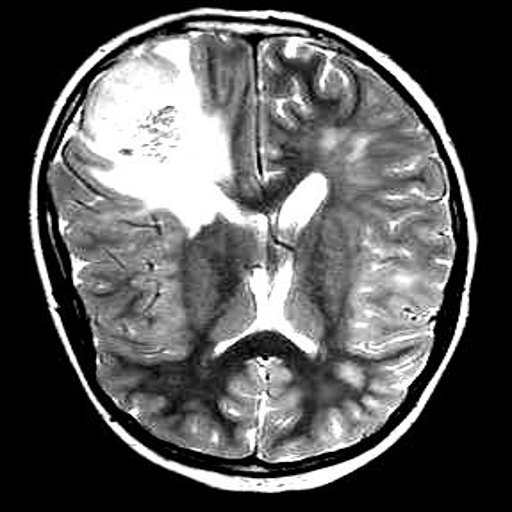

In [16]:
# Extract MRI ZIP (if present) and list images
import zipfile, os
EXTRACT_PATH = Path(EXTRACT_PATH)
if ZIP_PATH and ZIP_PATH.exists():
    EXTRACT_PATH.mkdir(parents=True, exist_ok=True)
    try:
        with zipfile.ZipFile(ZIP_PATH, 'r') as zf:
            zf.extractall(EXTRACT_PATH)
        print('Extracted ZIP to', EXTRACT_PATH)
    except Exception as e:
        print('Failed to extract ZIP:', e)
else:
    print('No ZIP file found at', ZIP_PATH)

# find images
img_patterns = ['**/*.png','**/*.jpg','**/*.jpeg','**/*.bmp']
mri_images = []
for p in img_patterns:
    mri_images.extend(list(EXTRACT_PATH.glob(p)))
mri_images = sorted(mri_images)
print('Found', len(mri_images), 'images. Sample:', [str(x.name) for x in mri_images[:5]])

# Display first image inline (if available)
from IPython.display import display
if mri_images:
    sample = mri_images[0]
    print('Displaying sample image:', sample.name)
    display(Image.open(sample).resize((512,512)))
else:
    print('No images to display.')

In [37]:
# ==========================================
# 🧠 EHR + MRI Summarization with ICD10 + Visualization (10 Samples)
# ==========================================

from IPython.display import display, HTML
from pathlib import Path
import zipfile, os
import torch
from PIL import Image
import pandas as pd

# ✅ Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define paths
CSV_PATH = Path("/content/drive/MyDrive/Merged_EHR_Data.csv")
ZIP_PATH = Path("/content/drive/MyDrive/mri_images.zip")
EXTRACT_PATH = Path("/content/drive/MyDrive/mri_images")
OUTPUT_DIR = Path("/content/drive/MyDrive/patient_reports")

EXTRACT_PATH.mkdir(parents=True, exist_ok=True)
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# ==========================================
# 🧩 Load EHR data
# ==========================================
if CSV_PATH.exists():
    df = pd.read_csv(CSV_PATH)
    print(f"✅ Loaded EHR Data: {len(df)} records")
else:
    raise FileNotFoundError("❌ EHR CSV file not found in Google Drive!")

# ==========================================
# 🧩 Extract MRI ZIP and list images
# ==========================================
if ZIP_PATH.exists():
    try:
        with zipfile.ZipFile(ZIP_PATH, 'r') as zf:
            zf.extractall(EXTRACT_PATH)
        print("✅ Extracted MRI ZIP to", EXTRACT_PATH)
    except Exception as e:
        print("❌ Failed to extract ZIP:", e)
else:
    print("⚠️ No ZIP file found at", ZIP_PATH)

# Collect all MRI images
img_patterns = ['**/*.png','**/*.jpg','**/*.jpeg','**/*.bmp']
mri_images = []
for p in img_patterns:
    mri_images.extend(list(EXTRACT_PATH.glob(p)))
mri_images = sorted(mri_images)
print(f"🖼️ Found {len(mri_images)} MRI images. Sample:", [x.name for x in mri_images[:5]])

# ==========================================
# ⚙️ Load Hugging Face Models
# ==========================================
from transformers import BlipProcessor, BlipForConditionalGeneration, AutoTokenizer, AutoModelForSeq2SeqLM

device = "cuda" if torch.cuda.is_available() else "cpu"

# MRI Caption Model
caption_model_name = "Salesforce/blip-image-captioning-base"
processor = BlipProcessor.from_pretrained(caption_model_name)
caption_model = BlipForConditionalGeneration.from_pretrained(caption_model_name).to(device)

# EHR Summarization Model
ehr_model_name = "google/flan-t5-large"
ehr_tokenizer = AutoTokenizer.from_pretrained(ehr_model_name)
ehr_model = AutoModelForSeq2SeqLM.from_pretrained(ehr_model_name).to(device)

# ==========================================
# 🧠 Helper Functions
# ==========================================
def analyze_mri_image(img_path):
    """Generate caption for an MRI image using BLIP model"""
    try:
        image = Image.open(img_path).convert("RGB")
        inputs = processor(images=image, return_tensors="pt").to(device)
        output_ids = caption_model.generate(**inputs, num_beams=5, max_length=50,
                                            repetition_penalty=2.5, length_penalty=1.0, early_stopping=True)
        caption = processor.decode(output_ids[0], skip_special_tokens=True).strip()
        if "mri" not in caption.lower():
            caption = f"MRI scan shows: {caption}"
        return caption
    except Exception as e:
        return f"Error generating caption: {e}"

def summarize_ehr_text(text):
    """Summarize clinical notes using FLAN-T5"""
    try:
        input_text = f"Summarize this medical record: {text}"
        inputs = ehr_tokenizer(input_text, return_tensors="pt", truncation=True, max_length=512).to(device)
        outputs = ehr_model.generate(**inputs, max_length=100, num_beams=4, early_stopping=True)
        summary = ehr_tokenizer.decode(outputs[0], skip_special_tokens=True)
        return summary
    except Exception as e:
        return f"Error summarizing EHR: {e}"

# ==========================================
# 🧾 Generate Reports (10 Samples)
# ==========================================
reports = []
N = min(10, len(df))

for idx, row in df.head(N).iterrows():
    pid = row["Patient_ID"]
    gender = row["Gender"]
    age = row["Age"]
    glucose = row["Avg_Glucose_Level (mg/dL)"]
    bmi = row["BMI"]
    clinical_notes = row["Clinical_Notes"]
    icd_code = row["ICD10_Code"]
    icd_desc = row["ICD10_Description"]

    # ✅ Sequentially assign MRI image from the list
    chosen_img = mri_images[idx] if idx < len(mri_images) else None

    # Generate AI summaries
    ehr_summary = summarize_ehr_text(clinical_notes)
    caption = analyze_mri_image(str(chosen_img)) if chosen_img else "No MRI available"

    # Prepare report text for saving
    report_text = f"""
PATIENT REPORT - {pid}
Gender: {gender}
Age: {age}
Glucose Level: {glucose} mg/dL
BMI: {bmi}
ICD-10 Code: {icd_code}
ICD-10 Description: {icd_desc}

Clinical Notes: {clinical_notes}
EHR Summary: {ehr_summary}
MRI Caption: {caption}
"""
    (OUTPUT_DIR / f"report_{pid}.txt").write_text(report_text)

    # Save structured data
    reports.append({
        "Patient_ID": pid,
        "Gender": gender,
        "Age": age,
        "Glucose_Level": glucose,
        "BMI": bmi,
        "ICD10_Code": icd_code,
        "ICD10_Description": icd_desc,
        "Clinical_Notes": clinical_notes,
        "EHR_Summary": ehr_summary,
        "MRI_Caption": caption,
        "Image_Path": str(chosen_img) if chosen_img else ""
    })

    # ===============================
    # 🖼️ Display patient report with image
    # ===============================
    if chosen_img:
        img_tag = f"<img src='{chosen_img}' width='300' style='border-radius:10px;margin:10px;'>"
    else:
        img_tag = "<p><i>No MRI image available</i></p>"

    display(HTML(f"""
    <div style='border:2px solid #ccc;border-radius:10px;padding:15px;margin:15px;background:#f9f9f9;'>
        <h3>🧬 PATIENT REPORT - {pid}</h3>
        {img_tag}
        <p><b>Gender:</b> {gender}</p>
        <p><b>Age:</b> {age}</p>
        <p><b>Glucose Level:</b> {glucose} mg/dL</p>
        <p><b>BMI:</b> {bmi}</p>
        <p><b>ICD-10 Code:</b> {icd_code}</p>
        <p><b>ICD-10 Description:</b> {icd_desc}</p>
        <p><b>Clinical Notes:</b> {clinical_notes}</p>
        <p><b>EHR Summary:</b> {ehr_summary}</p>
        <p><b>MRI Caption:</b> {caption}</p>
    </div>
    """))

# ==========================================
# 💾 Save all patient summaries
# ==========================================
summary_df = pd.DataFrame(reports)
summary_df.to_csv(OUTPUT_DIR / "patient_reports_summary.csv", index=False)
print(f"✅ 10 reports saved to: {OUTPUT_DIR}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Loaded EHR Data: 100 records
✅ Extracted MRI ZIP to /content/drive/MyDrive/mri_images
🖼️ Found 500 MRI images. Sample: ['y0.jpg', 'y1.jpg', 'y10.jpg', 'y100.jpg', 'y101.jpg']


✅ 10 reports saved to: /content/drive/MyDrive/patient_reports


In [38]:
# Final tips & optional copy to Drive
print('If you mounted Google Drive earlier, you can copy outputs there:')
try:
    from google.colab import drive, files
    drive_root = Path('/content/drive/MyDrive/Medical_Reports')
    drive_root.mkdir(parents=True, exist_ok=True)
    # copy files
    import shutil
    shutil.copy('/content/patient_reports_summary.csv', drive_root/'patient_reports_summary.csv')
    print('Copied patient_reports_summary.csv to', drive_root)
except Exception as e:
    print('Drive copy skipped (not in Colab or mount failed):', e)

print('Notebook complete. If you want the .ipynb file downloaded, use the file browser or download from the runtime.')

If you mounted Google Drive earlier, you can copy outputs there:
Copied patient_reports_summary.csv to /content/drive/MyDrive/Medical_Reports
Notebook complete. If you want the .ipynb file downloaded, use the file browser or download from the runtime.
